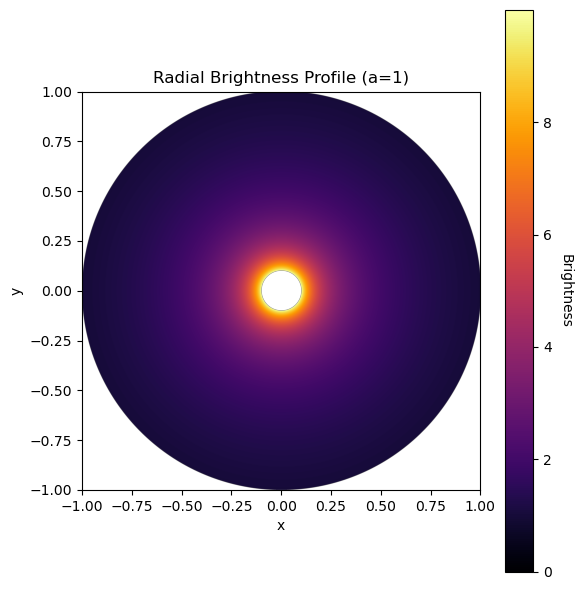

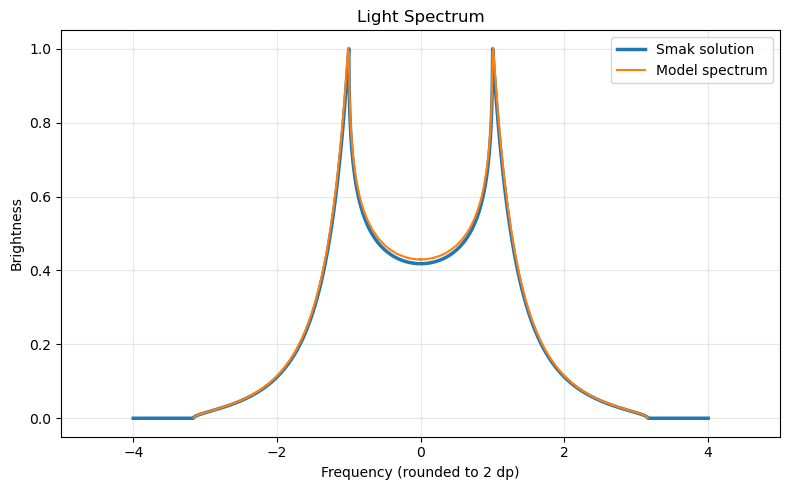

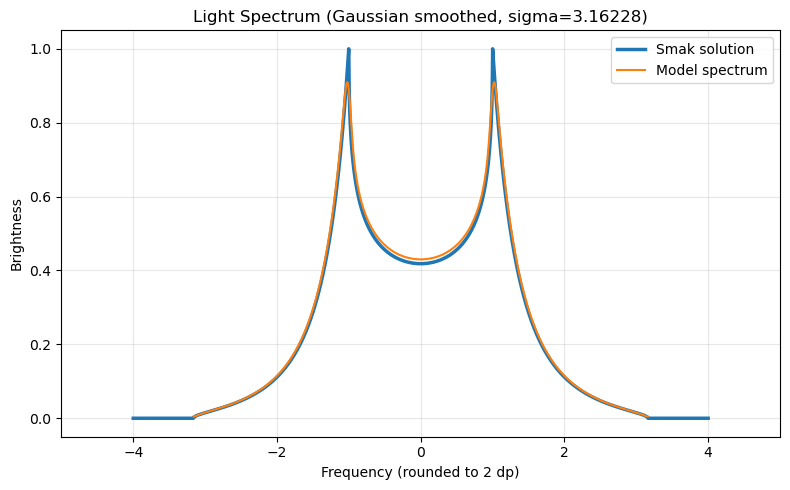

In [48]:
#Accretion Disc Model: Week 3

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ----- INITIALISE -----
Rmax = 1
Rmin = 0.1
N = 5000
eps = 1e-12

coords = np.linspace(-Rmax, Rmax, N)     # 1D coordinate vector
X, Y = np.meshgrid(coords, coords)       # 2D grid
R = np.hypot(X, Y)                       # distances from origin
theta = np.arctan2(Y, X)                 # angles from origin
mask = (R >= Rmin) & (R <= Rmax)         # points within the disc
extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting
# a = [0, 0.5, 1, 1.5, 2, 2.5]
a = 1

# ----- PROFILE FUNCTION -----
def profile2d(func, R, theta, mask,
              eps=1e-15,
              plot=False,
              colourmap="viridis",
              vmin=None, vmax=None,
              title="Profile",
              x_label="x", y_label="y",
              colour_bar_name="Value",
              extent=None,
              ax=None,
              symmetric=False,   # set symmetric color limits around 0 (for signed fields)
              nonneg=False       # force vmin=0 and vmax=max (for non-negative fields)
              ):
    """
    Compute a 2D profile from func(r, theta) on the masked domain, optionally plot it.
    """
    # Compute values
    values = np.full_like(R, np.nan, dtype=float)
    values[mask] = func(np.maximum(R[mask], eps), theta[mask])

    # Handle extent - CHAT
    if extent is None:
        # Fallback: infer square extent from max radius in mask
        rmax = np.nanmax(R[mask])
        extent = [-rmax, rmax, -rmax, rmax]

    # Auto color scaling helpers - CHAT
    if symmetric:
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto if vmin is None else vmin
        vmax_plot =  vmax_auto if vmax is None else vmax
    elif nonneg:
        vmin_plot = 0.0 if vmin is None else vmin
        vmax_plot = np.nanmax(values) if vmax is None else vmax
    else:
        vmin_plot = vmin
        vmax_plot = vmax

    # Optional plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        else:
            fig = ax.figure

        img = ax.imshow(
            values,
            extent=extent,
            origin="lower",
            cmap=colourmap,
            aspect="equal",
            vmin=vmin_plot, vmax=vmax_plot
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    return values

# ----- CREATE PROFILES -----

# Velocity-like profile: cos(t)/sqrt(r), signed -> use symmetric=True
velocity = profile2d(
    lambda r, t: np.cos(t) / np.sqrt(r),
    R, theta, mask,
    eps=eps,
    plot=0,
    colourmap="seismic",
    title="Doppler Shift",
    colour_bar_name="Velocity",
    extent=extent,
    symmetric=True
)

# Radial Brightness profile: r^(-a), non-negative -> use nonneg=True

brightnessrad = profile2d(
    lambda r, th: r**(-a),
    R, theta, mask,
    eps=eps,
    plot=1,
    colourmap="inferno",
    title=f"Radial Brightness Profile (a={a})",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)

# ----- DATA ANALYSIS -----

# Parameters
p = 2  # decimal places
# Extract net freq and brightness
frequency = np.round(velocity, p) # discretise by rounding
brightness = brightnessrad

# Keep valid points
valid = np.isfinite(frequency) & np.isfinite(brightness)
f = frequency[valid]
w = brightness[valid]

# Group by unique rounded frequency and sum brightness
unique_f, inverse = np.unique(f, return_inverse=True)
sum_brightness = np.bincount(inverse, weights=w)
# Result: unique_f (frequencies), sum_brightness (total brightness per frequency)

# Normalise max brightness to to 1
sum_brightness_norm = sum_brightness / np.max(sum_brightness)

# ----- SMAK ANALYTICAL SOLUTION -----

import numpy as np

def I(a, x):
    eps = 1e-12
    y = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            y = np.log(abs((1.0 - s) / x)) if abs(x) > eps else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return y

def I_difference(a, u, Rmin):
    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*np.sqrt(Rmin), -1.0, 1.0)
    return I(a, x_z) - I(a, x_1)

Smak_u = np.linspace(-4.0, 4.0, 4000)          # x_plotting
Smak_F = np.full_like(Smak_u, np.nan, float)   # y_plotting

exp = 2*a - 5
rootR = np.sqrt(Rmin)

for i, u in enumerate(Smak_u):
    # guard the singular prefactor at u=0 if exponent < 0
    if abs(u) < 1e-12 and exp < 0:
        Smak_F[i] = np.nan
        continue

    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*rootR, -1.0, 1.0)

    upper = I(a, x_z)
    lower = I(a, x_1)
    diff  = upper - lower

    Smak_F[i] = (u**exp) * diff

# normalise robustly (optional)
finite = np.isfinite(Smak_F)
if finite.any():
    amp = np.nanmax(np.abs(Smak_F))
    Smak_F_norm = Smak_F / amp if (np.isfinite(amp) and amp > 0) else Smak_F
else:
    Smak_F_norm = Smak_F

# ----- PLOT SPECTRUM -----

def plot_spectrum(unique_f,
                  sum_brightness_norm,
                  Smak_u=None,
                  Smak_F_norm=None,
                  *,
                  p=2,
                  xlim=(-5, 5),
                  Smak=False,
                  sigma=None,
                  xlabel="Frequency",
                  ylabel="Brightness",
                  title="Light Spectrum",
                  figsize=(8, 5),
                  grid_alpha=0.3):

    # Make safe copies
    x = np.asarray(unique_f)
    y = np.asarray(sum_brightness_norm)

    # Optional gaussian smoothing
    if sigma is not None and sigma > 0:
        if gaussian_filter1d is None:
            raise RuntimeError("gaussian_filter1d not available; install SciPy or remove smoothing.")
        y = gaussian_filter1d(y, sigma=sigma)
        title = f"{title} (Gaussian smoothed, sigma={sigma:g})"

    # Plot
    plt.figure(figsize=figsize)

    if Smak:
        if Smak_u is None or Smak_F_norm is None:
            raise ValueError("Smak=True but Smak_u/Smak_F_norm not provided.")
        plt.plot(Smak_u, Smak_F_norm, linestyle='-', linewidth=2.5, label='Smak solution')
        plt.plot(x, y, linestyle='-', label='Model spectrum')
        plt.legend()
    else:
        plt.plot(x, y, linestyle='-')

    plt.xlabel(f"{xlabel} (rounded to {p} dp)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.tight_layout()
    plt.show()

# Raw spectrum (no smoothing)
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=None, Smak=True, title="Light Spectrum"
)

# Smoothed spectrum
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=(10**(1/p)), Smak=True, title="Light Spectrum"
)


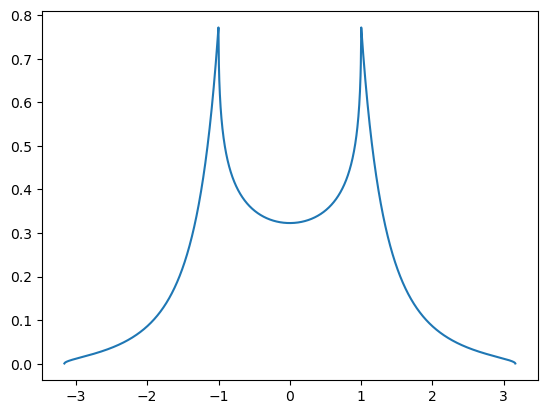

In [39]:
# ----- SMAK ANALYTICAL SOLUTION -----

import numpy as np

def I(a, x):
    """
    Analytical solution I(a, x).
    Returns np.nan if undefined (|x| > 1, or x=0 with a=2.5).
    """
    eps = 1e-12

    # default to NaN
    y = np.nan

    if abs(x) <= 1.0:          # inside disc
        s = np.sqrt(1.0 - x**2)

        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            if abs(x) > eps:   # avoid division by zero
                y = np.log(abs((1.0 - s) / x))
            else:
                y = np.nan     # undefined at x=0
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")

    return y

def I_difference(a, x):
    upper = I(a, x_z)
    lower = I(a, x)
    difference = upper - lower
    return difference

Smak_u = np.linspace(-4.0, 4.0, 4000) #x_plotting
Smak_F = np.full_like(Smak_u, np.nan) #y_plotting

for i in range(0, len(Smak_u) - 1, 1):

    x_1 = Smak_u[i] * Rmin**0.5
    x_z = np.clip(Smak_u[i], -1.0, 1.0)

    upper = I(a, x_z)
    lower = I(a, x_1)
    
    difference = upper - lower

    Smak_F[i] = Smak_u[i]**(2*a-5)*difference

plt.plot(Smak_u, Smak_F)



In [ ]:
# Linear Brightness profile: Rmax + rcos(th), non-negative -> use nonneg=True
brightnesslin = profile2d(
    lambda r, th: Rmax +r*np.cos(th),
    R, theta, mask,
    eps=eps,
    plot=False,
    colourmap="inferno",
    title=f"Linear Brightness Profile",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)